In [1]:
import numpy as np
import os
import ray
import sys
from pathlib import Path
from functools import partial
import weaviate
import json
import nltk
import openai
from openai import OpenAI

In [2]:
import matplotlib.pyplot as plt
from rag.preprocess import extract_sections, fetch_text
from rag.utils import get_num_tokens, trim

In [3]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer
import numpy as np
from ray.data import ActorPoolStrategy

In [4]:
from bs4 import BeautifulSoup
from IPython.display import JSON, clear_output, display
from tqdm import tqdm
import urllib.parse

In [6]:
# Ray dataset
EFS_DIR = "scikit_html_documents"
DOCS_DIR = Path(EFS_DIR)
ds = ray.data.from_items([{"path": path} for path in DOCS_DIR.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

C:\Users\bhujith.m\AppData\Local\anaconda3\lib\site-packages\ray\_private\node.py:1403: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\bhujith.m\\AppData\\Local\\Temp\\ray\\session_2023-11-27_00-01-53_658852_3924\\logs\\gcs_server.out' mode='a' encoding='utf-8'>
  self.start_gcs_server()
C:\Users\bhujith.m\AppData\Local\anaconda3\lib\site-packages\ray\_private\node.py:1403: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\bhujith.m\\AppData\\Local\\Temp\\ray\\session_2023-11-27_00-01-53_658852_3924\\logs\\gcs_server.err' mode='a' encoding='utf-8'>
  self.start_gcs_server()
C:\Users\bhujith.m\AppData\Local\anaconda3\lib\site-packages\ray\_private\node.py:1408: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\Users\\bhujith.m\\AppData\\Local\\Temp\\ray\\session_2023-11-27_00-01-53_658852_3924\\logs\\monitor.out' mode='a' encoding='utf-8'>
  self.start_monitor()
C:\Users\bhujith.m\AppData\Local\anaconda3\lib\site-packages\ray\_private\node.

599 documents


In [7]:
sample_html_fp = Path(EFS_DIR, "array_api.html")
extract_sections({"path": sample_html_fp})[0]

{'source': 'https://docs.ray.ioscikit_html_documents\\array_api.html#array-api-support-experimental',
 'text': '\n11.1. Array API support (experimental)¶\nThe Array API specification defines\na standard API for all array manipulation libraries with a NumPy-like API.\nScikit-learn’s Array API support requires\narray-api-compat to be installed.\nSome scikit-learn estimators that primarily rely on NumPy (as opposed to using\nCython) to implement the algorithmic logic of their fit, predict or\ntransform methods can be configured to accept any Array API compatible input\ndatastructures and automatically dispatch operations to the underlying namespace\ninstead of relying on NumPy.\nAt this stage, this support is considered experimental and must be enabled\nexplicitly as explained in the following.\nNote\nCurrently, only cupy.array_api, numpy.array_api, cupy, and PyTorch\nare known to work with scikit-learn’s estimators.'}

In [8]:
# Extract sections
sections_ds = ds.flat_map(extract_sections)
sections = sections_ds.take_all()
print (len(sections))

2023-11-27 00:02:55,950	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)]
2023-11-27 00:02:55,952	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-27 00:02:55,956	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

1536


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x147c031f400>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x147c031f520>


In [9]:
sections[0]

{'source': 'https://docs.ray.ioscikit_html_documents\\array_api.html#array-api-support-experimental',
 'text': '\n11.1. Array API support (experimental)¶\nThe Array API specification defines\na standard API for all array manipulation libraries with a NumPy-like API.\nScikit-learn’s Array API support requires\narray-api-compat to be installed.\nSome scikit-learn estimators that primarily rely on NumPy (as opposed to using\nCython) to implement the algorithmic logic of their fit, predict or\ntransform methods can be configured to accept any Array API compatible input\ndatastructures and automatically dispatch operations to the underlying namespace\ninstead of relying on NumPy.\nAt this stage, this support is considered experimental and must be enabled\nexplicitly as explained in the following.\nNote\nCurrently, only cupy.array_api, numpy.array_api, cupy, and PyTorch\nare known to work with scikit-learn’s estimators.'}

In [10]:
section_lengths = []
for section in sections_ds.take_all():
    section_lengths.append(len(section["text"]))

2023-11-27 00:03:23,150	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)]
2023-11-27 00:03:23,152	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-27 00:03:23,154	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1484dc617e0>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1484dc610c0>


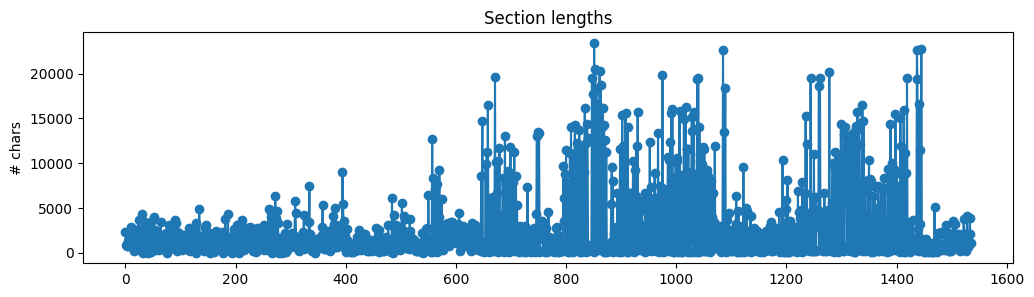

In [11]:
# Plot
plt.figure(figsize=(12, 3))
plt.plot(section_lengths, marker='o')
plt.title("Section lengths")
plt.ylabel("# chars")
plt.show()

In [12]:
from langchain.document_loaders import ReadTheDocsLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Text splitter
chunk_size = 300
chunk_overlap = 50
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len,
)

# Chunk a sample section
sample_section = sections_ds.take(1)[0]
chunks = text_splitter.create_documents(
    texts=[sample_section["text"]], 
    metadatas=[{"source": sample_section["source"]}])
print (chunks[0])

2023-11-27 00:04:08,803	INFO dataset.py:2380 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2023-11-27 00:04:08,813	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> LimitOperator[limit=1]
2023-11-27 00:04:08,815	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-27 00:04:08,817	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

page_content='11.1. Array API support (experimental)¶\nThe Array API specification defines\na standard API for all array manipulation libraries with a NumPy-like API.\nScikit-learn’s Array API support requires\narray-api-compat to be installed.' metadata={'source': 'https://docs.ray.ioscikit_html_documents\\array_api.html#array-api-support-experimental'}


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x148512a1060>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x148512a14e0>


In [13]:
def chunk_section(section, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len)
    chunks = text_splitter.create_documents(
        texts=[section["text"]], 
        metadatas=[{"source": section["source"]}])
    return [{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks]

In [14]:
# Scale chunking
chunks_ds = sections_ds.flat_map(partial(
    chunk_section, 
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap))
print(f"{chunks_ds.count()} chunks")
chunks_ds.show(1)

2023-11-27 00:04:25,737	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)]
2023-11-27 00:04:25,738	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-27 00:04:25,739	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x148512a2560>
2023-11-27 00:04:34,444	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)] -> LimitOperator[limit=1]
2023-11-27 00:04:34,445	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-27 00:04:34,445	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


20018 chunks


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'text': '11.1. Array API support (experimental)¶\nThe Array API specification defines\na standard API for all array manipulation libraries with a NumPy-like API.\nScikit-learn’s Array API support requires\narray-api-compat to be installed.', 'source': 'https://docs.ray.ioscikit_html_documents\\array_api.html#array-api-support-experimental'}


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x148512a2fe0>
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x148512a2ce0>


### Use of Partial function 

In [60]:
# from functools import partial

# # Original function
# def power(x, y):
#     return x ** y

# # Create a partially applied function
# square = partial(power, y=2)

# # Now, 'square' is a function where 'y' is fixed to 2
# result = square(5)
# print(result)  # Output: 25

In [17]:
def get_embedding_model(embedding_model_name, model_kwargs, encode_kwargs):
    if embedding_model_name == "text-embedding-ada-002":
        embedding_model = OpenAIEmbeddings(
            model=embedding_model_name,
            openai_api_key=keys["OPENAI_API_KEY"])
    else:
        embedding_model = HuggingFaceEmbeddings(
            model_name=embedding_model_name,  # also works with model_path
            model_kwargs=model_kwargs,
            encode_kwargs=encode_kwargs)
    return embedding_model

In [21]:
class EmbedChunks:
    def __init__(self, model_name):
        self.embedding_model = get_embedding_model(
            embedding_model_name=model_name,
            model_kwargs={"device": "cuda"},
            encode_kwargs={"device": "cuda", "batch_size": 100})
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "source": batch["source"], "embeddings": embeddings}

In [24]:
# Embed chunks
# Hugging face embedding model thenlper/gte-base
embedding_model_name = "text-embedding-ada-002"
embedded_chunks = chunks_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=100, 
    num_gpus=1,
    compute=ActorPoolStrategy(size=1))

In [25]:
# Sample
sample = embedded_chunks.take(1)
print ("embedding size:", len(sample[0]["embeddings"]))
print (sample[0]["text"])

2023-11-25 13:13:21,198	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)] -> ActorPoolMapOperator[MapBatches(EmbedChunks)] -> LimitOperator[limit=1]
2023-11-25 13:13:21,200	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-25 13:13:21,202	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-11-25 13:13:21,248	INFO actor_pool_map_operator.py:106 -- MapBatches(EmbedChunks): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

2023-11-25 13:13:46,427	WARNING actor_pool_map_operator.py:265 -- Your batch size is too large. Currently, your batch size is 100. Your dataset contains 53, and Ray Data tried to parallelize it across 1 actors. To parallelize this fully across all 1 actors, set batch size to not exceed `53 / 1 = 53`.


embedding size: 1536
ray.job_submission.JobDetails.runtime_env#
JobDetails.runtime_env: Optional[Dict[str, Any]]#


In [26]:
sample

[{'text': 'ray.job_submission.JobDetails.runtime_env#\nJobDetails.runtime_env: Optional[Dict[str, Any]]#',
  'source': 'https://docs.ray.io\\en\\master\\cluster\\running-applications\\job-submission\\doc\\ray.job_submission.JobDetails.runtime_env.html#ray-job-submission-jobdetails-runtime-env',
  'embeddings': [-0.023963686471783166,
   -0.031864915565689406,
   0.0023580904039774246,
   -0.010732380849296699,
   -0.035562746810004535,
   0.027054843005173617,
   -0.010262929071411426,
   -0.020251410414098864,
   -0.03862501371665663,
   -0.021248091360700938,
   0.0011041135475433773,
   0.0024068409506064516,
   0.03128712675621272,
   -0.007023714597970804,
   -2.7365853833044276e-05,
   0.0018010682256100815,
   0.004911183460132252,
   -0.003936169267922648,
   0.04524066745922246,
   -9.377742543707303e-05,
   0.017940264489418024,
   0.019818069738313942,
   -0.034031611494033304,
   -0.013354085604801875,
   -0.003751999760110833,
   0.004968962247947661,
   0.0146107713294039

## Creating Weaviate client

In [15]:
client = weaviate.Client(
    url = "https://bhujith-weaviate-bjmg7g0q.weaviate.network",  # Replace with your endpoint
    auth_client_secret=weaviate.AuthApiKey(api_key=keys['WEAVIATE_API_KEY']),  # Replace w/ your Weaviate instance API key
    additional_headers = {
        "X-OpenAI-Api-Key": keys['OPENAI_API_KEY']  # Replace with your inference API key
    }
)

In [16]:
if client.schema.exists("ScikitLearnDocumentation"):
    client.schema.delete_class("ScikitLearnDocumentation")

## Creating Weaviate class schema

In [17]:
class_obj = {
    "class": "ScikitLearnDocumentation",
    "vectorizer": "text2vec-openai",  # If set to "none" you must always provide vectors yourself. Could be any other "text2vec-*" also.
    "moduleConfig": {
        "text2vec-openai": {},
        "generative-openai": {}  # Ensure the `generative-openai` module is used for generative queries
    }
}

class_obj['properties'] = [{
            "name": "text",
            "dataType": ["string"],
            "description": "The Documentation text chunk", 
            "moduleConfig": {
                "text2vec-openai": {  
                    "skip" : False,
                    "vectorizePropertyName" : False
                }
            }        
        },
          {
            "name": "source",
            "dataType": ["string"],
            "description": "The source of the text chunk in the documentation", 
            "moduleConfig": {
                "text2vec-openai": {  
                    "skip" : True,
                    "vectorizePropertyName" : False
                }
            }        
        }
]

client.schema.create_class(class_obj)

In [18]:
for chunk in chunks_ds.iter_rows():
    print(chunk)
    break

{'text': '1.3. Kernel ridge regression¶\nKernel ridge regression (KRR) [M2012] combines Ridge regression and classification\n(linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear\nfunction in the space induced by the respective kernel and the data. For', 'source': 'https://docs.ray.ioscikit_html_documents\\kernel_ridge.html#kernel-ridge-regression'}


## Importing data into Weaviate VectorDB

In [19]:
# Configure batch process - for faster imports 
n_retries = 5
batch_size = 100
client.batch.configure(batch_size=batch_size,
                      timeout_retries=n_retries,           # Number of retries if a timeout occurs
                      connection_error_retries=n_retries  # Number of retries if a connection error occurs
                      )

# Importing the data
for chunk in chunks_ds.iter_rows():

    chunk_object = {
        'text': chunk['text'],
        'source': chunk['source']
    }

    client.batch.add_data_object(chunk_object, "ScikitLearnDocumentation")

## Retrieval

In [21]:
'''
To use if hugging face transformers are used for embeddings
Also, replace "with_near_vector" function with "with_near_vector"
'''
# model = SentenceTransformer('sentence-transformers/paraphrase-xlm-r-multilingual-v1')
# embeddings = model.encode(input_query)
# input_vector = {"vector": list(embeddings[0].astype('float64'))}

'''
To use OpenAI embeddings
'''
input_query = "How to build linear regression model?"
response = (
    client.query
    .get("ScikitLearnDocumentation", ["text", "source"])
    .with_near_text({"concepts":[input_query]})
    .with_limit(10)
    .do()
)

print(json.dumps(response, indent=4))

{
    "data": {
        "Get": {
            "ScikitLearnDocumentation": [
                {
                    "source": "https://docs.ray.ioscikit_html_documents\\linear_model.html#ordinary-least-squares",
                    "text": "Linear Regression Example"
                },
                {
                    "source": "https://docs.ray.ioscikit_html_documents\\learning_curve.html#validation-curves-plotting-scores-to-evaluate-models",
                    "text": "to fit the function: linear regression with polynomial features of degree 1,\n4 and 15. We see that the first estimator can at best provide only a poor fit\nto the samples and the true function because it is too simple (high bias),"
                },
                {
                    "source": "https://docs.ray.ioscikit_html_documents\\sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier",
                    "text": "especially in regression."
                },
                {
      

## Retrieval Augmented Generation 

Input a query.

The query will be fed into the weaviate vector db and the most similar vectors will be retrieved along with the corresponding text.

The top retrieved text chunks will be provided as context to the LLM.

In [71]:
context='\n'.join([ans['text'] for ans in response['data']['Get']['ScikitLearnDocumentation'][:5]])
user_query='what is default batch size for map-batches?'

#llm="meta-llama/Llama-2-70b-chat-hf"
temperature=0.0,
system_content="Answer the query using the context provided. Be succinct."
user_content=f"query:{user_query} context:{context}"

client = OpenAI(
    api_key=keys["OPENAI_API_KEY"],
)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": system_content 
        },
        {
            "role": "assistant", 
            "content": "Hello, How can I help you?"},
        {
            "role": "user",
            "content": user_content,
        }
    ],
    model="gpt-4",
    stream=False
)


In [70]:
## For streaming response
for content in chat_completion:
    print(content.choices[0].delta.content, end='', flush=True)

The default batch size for map_batches in ray.data.Dataset is 4096.None

In [72]:
## For non streaming response
chat_completion.choices[0].message.content

'The default batch size for map-batches is 4096.'

## Building QueryAgent

In [24]:
def get_top_answers_from_vector_db(input_query,num_chunks):
    n_top_results = 5
    response = (
        client.query
        .get("ScikitLearnDocumentation", ["text", "source"])
        .with_near_text({"concepts":[input_query]})
        .with_limit(num_chunks)
        .do()
    ) 
    top_responses = [ans['text'] for ans in response['data']['Get']['ScikitLearnDocumentation'][:n_top_results]]
    top_sources = [ans['source'] for ans in response['data']['Get']['ScikitLearnDocumentation'][:n_top_results]]
    return top_responses,top_sources

def generate_response(llm,system_content,assistant_content,user_content):
    client = OpenAI(
        api_key=keys["OPENAI_API_KEY"]
    )
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_content 
            },
            {
                "role": "assistant", 
                "content": assistant_content
            },
            {
                "role": "user",
                "content": user_content
            }
        ],
        model=llm,
        stream=False
    )
    return chat_completion.choices[0].message.content

class QueryAgent:
    def __init__(self, llm, max_context_length=4096, system_content="", assistant_content=""):
        
        # Context length (restrict input length to 50% of total context length)
        max_context_length = int(0.5*max_context_length)
        
        # LLM
        self.llm = llm
        self.context_length = max_context_length - get_num_tokens(system_content + assistant_content)
        self.system_content = system_content
        self.assistant_content = assistant_content

    def __call__(self, query, num_chunks=5):
        # Get sources and context
        context,sources = get_top_answers_from_vector_db(query,num_chunks)
            
        # Generate response
        user_content = f"query: {query}, context: {context}"
        answer = generate_response(
            llm=self.llm,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=trim(user_content, self.context_length))

        # Result
        result = {
            "question": query,
            "sources": sources,
            "answer": answer,
            "llm": self.llm,
        }
        return result

In [27]:
query = "what is alpha in lasso regression model?"
system_content = "Answer the query using the context provided. Be succinct."
llm = "gpt-4"
agent = QueryAgent(
    llm=llm,
    system_content=system_content)
result = agent(query=query)
print("\n\n", json.dumps(result, indent=2))



 {
  "question": "what is alpha in lasso regression model?",
  "sources": [
    "https://docs.ray.ioscikit_html_documents\\sklearn.linear_model.Lasso.html#sklearn-linear-model-lasso",
    "https://docs.ray.ioscikit_html_documents\\sklearn.linear_model.ElasticNet.html#sklearn-linear-model-elasticnet",
    "https://docs.ray.ioscikit_html_documents\\sklearn.linear_model.LassoLars.html#sklearn-linear-model-lassolars",
    "https://docs.ray.ioscikit_html_documents\\sklearn.linear_model.LassoLarsIC.html#sklearn-linear-model-lassolarsic",
    "https://docs.ray.ioscikit_html_documents\\sklearn.linear_model.LassoLarsCV.html#sklearn-linear-model-lassolarscv"
  ],
  "answer": "Alpha in Lasso regression model is a parameter that controls the amount of shrinkage: the larger the value of alpha, the greater the amount of shrinkage and thus the coefficients become more robust to collinearity. It determines the amount of penalization on the coefficients in the model to prevent overfitting.",
  "llm":

## Evaluation

In [91]:
# Load dataset
with open(Path("eval-dataset-v1.jsonl"), "r",encoding='utf-8') as f:
    data = [json.loads(item) for item in list(f)]

In [93]:
data[:3]

[{'question': 'I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?',
  'source': 'https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format'},
 {'question': 'How does autoscaling work in a Ray Serve application?',
  'source': 'https://docs.ray.io/en/master/serve/scaling-and-resource-allocation.html#autoscaling'},
 {'question': 'how do I get the address of a ray node',
  'source': 'https://docs.ray.io/en/master/ray-core/miscellaneous.html#node-information'}]

In [96]:
# Sample
uri = "https://docs.ray.io/en/master/data/transforming-data.html#configuring-batch-format"
fetch_text(uri=uri)

'\nConfiguring batch format#\nRay Data represents batches as dicts of NumPy ndarrays or pandas DataFrames. By\ndefault, Ray Data represents batches as dicts of NumPy ndarrays.\nTo configure the batch type, specify batch_format in\nmap_batches(). You can return either format from your function.\n\n\n\nNumPy\nfrom typing import Dict\nimport numpy as np\nimport ray\n\ndef increase_brightness(batch: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:\n    batch["image"] = np.clip(batch["image"] + 4, 0, 255)\n    return batch\n\nds = (\n    ray.data.read_images("s3://anonymous@ray-example-data/image-datasets/simple")\n    .map_batches(increase_brightness, batch_format="numpy")\n)\n\n\n\n\n\npandas\nimport pandas as pd\nimport ray\n\ndef drop_nas(batch: pd.DataFrame) -> pd.DataFrame:\n    return batch.dropna()\n\nds = (\n    ray.data.read_csv("s3://anonymous@air-example-data/iris.csv")\n    .map_batches(drop_nas, batch_format="pandas")\n)\n\n\n\n\n'

In [106]:
def get_top_answers_from_vector_db(input_query,num_chunks):
    n_top_results = 5
    response = (
        client.query
        .get("ScikitLearnDocumentation", ["text", "source"])
        .with_near_text({"concepts":[input_query]})
        .with_limit(num_chunks)
        .do()
    ) 
    top_responses = [ans['text'] for ans in response['data']['Get']['ScikitLearnDocumentation'][:n_top_results]]
    top_sources = [ans['source'] for ans in response['data']['Get']['ScikitLearnDocumentation'][:n_top_results]]
    return top_responses,top_sources

def generate_response(llm,system_content,assistant_content,user_content):
    client = OpenAI(
        api_key=keys["OPENAI_API_KEY"]
    )
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_content 
            },
            {
                "role": "assistant", 
                "content": assistant_content
            },
            {
                "role": "user",
                "content": user_content
            }
        ],
        model=llm,
        stream=False
    )
    return chat_completion.choices[0].message.content

class QueryAgentWithContext:
    def __init__(self, llm, max_context_length=4096, system_content="", assistant_content=""):
        
        # Context length (restrict input length to 50% of total context length)
        max_context_length = int(0.5*max_context_length)
        
        # LLM
        self.llm = llm
        self.temperature = temperature
        self.context_length = max_context_length - get_num_tokens(system_content + assistant_content)
        self.system_content = system_content
        self.assistant_content = assistant_content

    def __call__(self, query, context):
            
        # Generate response
        user_content = f"query: {query}, context: {context}"
        answer = generate_response(
            llm=self.llm,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=trim(user_content, self.context_length))

        # Result
        result = json.loads(answer)
        return result

In [123]:
def evaluate(data, system_content="", llm='gpt4'):
    agent = QueryAgentWithContext(llm=llm,system_content=system_content)
    results = []
    for record in tqdm(data):
        try:
            response = agent(query=record['question'], context=fetch_text(record['source']))
        except:
            response = {'answer':'','score':-1,'reasoning':'file not found'}
        result = {
            'question': record['question'],
            'source': record['source'],
            'answer': response['answer'],
            'score': int(response['score']),
            'reasoning': response['reasoning']
        }
        results.append(result)
    return results

In [ ]:
system_content = """
    Answer the query using the context provided. Be succinct.
    Then, you must {score} your response between 1 and 5.
    You must return your response in a line with only the score.
    Do not add any more details.
    On a separate line provide your {reasoning} for the score as well.
    Return your response following the exact format outlined below.
    Do not add or remove anything.
    And all of this must be in a valid JSON format.
    
    {"answer": answer,
     "score": score,
     "reasoning": reasoning}
    """
llm = "gpt-4"
results = evaluate(data,system_content,llm)

In [121]:
results

[{'question': 'How does autoscaling work in a Ray Serve application?',
  'source': 'https://docs.ray.io/en/master/serve/scaling-and-resource-allocation.html#autoscaling',
  'answer': '',
  'score': -1,
  'reasoning': 'file not found'}]

## Keyword based search

In [13]:
response = (
    client.query
    .get("ScikitLearnDocumentation", ["text", "source"])
    .with_bm25(
      query="I’m struggling a bit with Ray Data type conversions when I do map_batches. Any advice?"
    )
    .with_additional("score")
    .with_limit(5)
    .do()
)


In [14]:
response

{'data': {'Get': {'RayDocumentation': [{'_additional': {'score': '6.476082'},
     'source': 'https://docs.ray.io\\en\\master\\tune\\faq.html#ray-tune-faq',
     'text': 'How can I use large datasets in Tune?\nHow can I upload my Tune results to cloud storage?\nHow can I use Tune with Docker?\nHow can I use Tune with Kubernetes?\nHow do I configure search spaces?\nHow do I access relative filepaths in my Tune training function?'},
    {'_additional': {'score': '5.9126'},
     'source': 'https://docs.ray.io\\en\\master\\serve\\advanced-guides\\app-builder-guide.html#defining-an-application-builder',
     'text': 'To avoid writing code to handle type conversions and missing arguments, use a Pydantic object instead.'},
    {'_additional': {'score': '5.8048387'},
     'source': 'https://docs.ray.io\\en\\master\\train\\user-guides\\data-loading-preprocessing.html#preprocessing-structured-data',
     'text': 'Preprocessing structured data#\nNote\nThis section is for tabular/structured data. 

## To be contd